In [1]:
from keras.models import load_model

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.ops import unary_union

In [2]:
mlp_model = load_model("Data\my_model1.1.h5")

In [3]:
poa = gpd.read_file("Shape\poa_selected.gpkg")
sa1_to_lga = gpd.read_file("Shape\sa1_to_lga.gpkg")
sa1 = gpd.read_file("Shape\sa1_to_poa.gpkg")
lga = gpd.read_file("Shape\LGA_2021_AUST_GDA2020_SHP\LGA_2021_AUST_GDA2020.shp")

sa2 = gpd.read_file("Shape\SA2_2021_AUST_SHP_GDA2020\SA2_2021_AUST_GDA2020.shp")
sa3 = gpd.read_file("Shape\SA3_2021_AUST_SHP_GDA2020\SA3_2021_AUST_GDA2020.shp")

sa1 = sa1[["POA_CODE21", "SA1_CODE21", "SA2_CODE21", "SA3_CODE21", "SA4_CODE21", "geometry"]]
poa = poa[["POA_CODE21", "geometry"]]

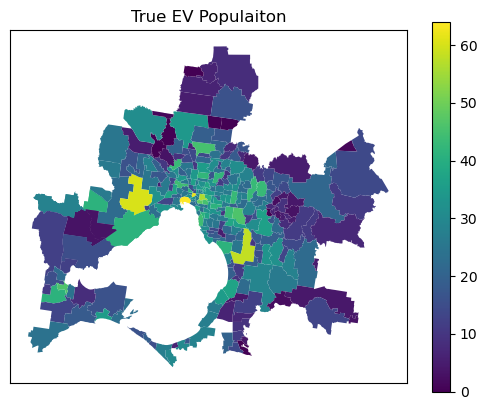

In [4]:
rego = pd.read_csv("Data\poa_ev.csv")
rego["POA_CODE21"] = rego["POA_CODE21"].astype(str)
true_ev_poa = poa.merge(rego, left_on="POA_CODE21", right_on="POA_CODE21", how="inner", )
ax = true_ev_poa.plot(column="TOTAL1", cmap='viridis', legend = True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("True EV Populaiton")
plt.show()

## SA1

In [5]:
synthetic = pd.read_csv("Data\clean1.1_data.csv")
synthetic["SA1"] = synthetic["SA1"].astype(str)
synthetic_sa1 = sa1.merge(synthetic, left_on="SA1_CODE21", right_on="SA1", how="right")

In [6]:
# categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Other", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
#                        "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free", "owndwell_Something Else"]

# hist_values = []
# num_bins = 10 

# sa1_list = synthetic_sa1["SA1"].unique()
# i = 0

# for sa1_selected in sa1_list:
#     hist_values_sa1 = []
#     selected = synthetic_sa1[synthetic_sa1["SA1"] == sa1_selected]

#     i = i + 1
#     if i % 100 == 0:  
#         print(i)

#     for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
#         hist, _ = np.histogram(selected[attribute], bins=num_bins)
#         hist_values_sa1.extend(hist)
    
#     categorical_sums = selected[categorical_columns].sum().values
#     hist_values_sa1.extend(categorical_sums)

#     hist_values.append(hist_values_sa1)

# data = np.array(hist_values)
# np.savetxt("Data\sa1_hist1.1.csv", data, delimiter=",")

In [7]:
loaded_hist_sa1 = np.loadtxt("Data\sa1_hist1.1.csv", delimiter=",")
sa1_list = synthetic_sa1["SA1"].unique()
sa1_pred = mlp_model.predict(loaded_hist_sa1).flatten()
data_array_sa1 = {'SA1_CODE21': sa1_list, 'pred_evs': sa1_pred}
sa1_pred = pd.DataFrame(data_array_sa1)
sa1_pred.to_csv("Data\pred_evs_sa1", index=False)

374/374 [==============================] - 1s 902us/step


In [8]:
pred_sa1_geo = sa1.merge(sa1_pred, on="SA1_CODE21", how="left")
pred_sa1_geo.loc[pd.isna(pred_sa1_geo["pred_evs"]), "pred_evs"] = 0

## POA

In [9]:
# categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Other", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
#                        "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free", "owndwell_Something Else"]


# hist_values = []
# num_bins = 10 

# poa_list = synthetic_sa1["POA_CODE21"].unique()

# for postcode in poa_list:
#     hist_values_postcode = []
#     selected = synthetic_sa1[synthetic_sa1["POA_CODE21"] == postcode]

#     for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
#         hist, _ = np.histogram(selected[attribute], bins=num_bins)
#         hist_values_postcode.extend(hist)
    
#     categorical_sums = selected[categorical_columns].sum().values
#     hist_values_postcode.extend(categorical_sums)

#     hist_values.append(hist_values_postcode)

# data = np.array(hist_values)
# np.savetxt("Data\poa_hist1.1.csv", data, delimiter=",")

In [10]:
poa_list = synthetic_sa1["POA_CODE21"].unique()
loaded_hist_poa = np.loadtxt("Data\poa_hist1.1.csv", delimiter=",")
pred_poa = mlp_model.predict(loaded_hist_poa).flatten()
data_array_poa = {'POA_CODE21': poa_list, 'pred_evs': pred_poa}
pred_poa = pd.DataFrame(data_array_poa)

9/9 [==============================] - 0s 1ms/step


In [11]:
pred_poa_geo = poa.merge(pred_poa, on="POA_CODE21", how="left")
pred_poa_geo.loc[pd.isna(pred_poa_geo["pred_evs"]), "pred_evs"] = 0

## LGA

In [12]:
synthetic = pd.read_csv("Data\clean1.1_data.csv")
synthetic["SA1"] = synthetic["SA1"].astype(str)
synthetic_lga = sa1_to_lga.merge(synthetic, left_on="SA1_CODE21", right_on="SA1", how="right")

In [13]:
categorical_columns = ["dwelltype_Flat or Apartment", "dwelltype_Other", "dwelltype_Separate House", "dwelltype_Terrace/Townhouse",
                       "owndwell_Being Purchased", "owndwell_Being Rented", "owndwell_Fully Owned", "owndwell_Occupied Rent-Free", "owndwell_Something Else"]


hist_values = []
num_bins = 10 

lga_list = synthetic_lga["LGA_CODE21"].unique()

for lga_selected in lga_list:
    hist_values_postcode = []
    selected = synthetic_lga[synthetic_lga["LGA_CODE21"] == lga_selected]

    for attribute in ["INC", "TOTALVEHS", "HHSIZE"]:
        hist, _ = np.histogram(selected[attribute], bins=num_bins)
        hist_values_postcode.extend(hist)
    
    categorical_sums = selected[categorical_columns].sum().values
    hist_values_postcode.extend(categorical_sums)

    hist_values.append(hist_values_postcode)

data = np.array(hist_values)
np.savetxt("Data\lga_hist1.1.csv", data, delimiter=",")

In [14]:
loaded_hist_sa1 = np.loadtxt("Data\lga_hist1.1.csv", delimiter=",")
lga_list = synthetic_lga["LGA_CODE21"].unique()
lga_pred = mlp_model.predict(loaded_hist_sa1).flatten()
data_array_lga = {'LGA_CODE21': lga_list, 'pred_evs': lga_pred}
lga_pred = pd.DataFrame(data_array_lga).dropna()
lga_pred.to_csv("Data\pred_evs_lga", index=False)

2/2 [==============================] - 0s 3ms/step


In [15]:
lga_pred["LGA_CODE21"] = lga_pred["LGA_CODE21"].astype(str)
lga["LGA_CODE21"] = lga["LGA_CODE21"].astype(str)

pred_lga_geo = lga.merge(lga_pred, on="LGA_CODE21", how="right")
pred_lga_geo.loc[pd.isna(pred_lga_geo["pred_evs"]), "pred_evs"] = 0

## Plotting

### Generate 

In [16]:
# pred_sa1_sa4 = pred_sa1_geo[["POA_CODE21", "SA1_CODE21", "SA2_CODE21", "SA3_CODE21", "SA4_CODE21", "pred_evs", "geometry"]]

# combined_shape = unary_union(sa1.geometry)

# pred_sa2 = pred_sa1_sa4.groupby("SA2_CODE21").sum("sa1_pred").reset_index()
# pred_sa2 = sa2.merge(pred_sa2, on="SA2_CODE21", how="right")[["SA2_CODE21", "geometry", "pred_evs"]]
# clipped_pred_sa2 = gpd.overlay(pred_sa2, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")

# pred_sa3 = pred_sa1_sa4.groupby("SA3_CODE21").sum("sa1_pred").reset_index()
# pred_sa3 = sa3.merge(pred_sa3, on="SA3_CODE21", how="right")[["SA3_CODE21", "geometry", "pred_evs"]]
# clipped_pred_sa3 = gpd.overlay(pred_sa3, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")

# pred_poa = pred_sa1_sa4.groupby("POA_CODE21").sum("sa1_pred").reset_index()
# pred_poa = poa.merge(pred_poa, on="POA_CODE21", how="right")[["POA_CODE21", "geometry", "pred_evs"]]
# clipped_pred_poa = gpd.overlay(pred_poa, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")

# pred_lga = lga_pred.groupby("LGA_CODE21").sum("pred_evs").reset_index()
# pred_lga = lga.merge(lga_pred, on="LGA_CODE21", how="right")[["LGA_CODE21", "geometry", "pred_evs"]].dropna()
# clipped_pred_lga = gpd.overlay(pred_lga, gpd.GeoDataFrame(geometry=[combined_shape]), how="intersection")

# pred_sa1_sa4.to_file("Predictions\pred_sa1.geojson", driver='GeoJSON')
# clipped_pred_sa2.to_file("Predictions\pred_sa2.geojson", driver='GeoJSON')
# clipped_pred_sa3.to_file("Predictions\pred_sa3.geojson", driver='GeoJSON')
# clipped_pred_poa.to_file("Predictions\pred_poa_ag.geojson", driver='GeoJSON')
# clipped_pred_lga.to_file("Predictions\pred_lga.geojson", driver='GeoJSON')
# true_ev_poa.to_file("Predictions\\true_ev.geojson", driver='GeoJSON')
# pred_lga_geo.to_file("Predictions\pred_poa.geojson", driver='GeoJSON')

### Read In

In [17]:
pred_sa1_sa4 = gpd.read_file("Predictions\pred_sa1.geojson")
clipped_pred_sa2 = gpd.read_file("Predictions\pred_sa2.geojson")
clipped_pred_sa3 = gpd.read_file("Predictions\pred_sa3.geojson")

clipped_pred_lga = gpd.read_file("Predictions\pred_poa.geojson")
# clipped_pred_poa = gpd.read_file("Predictions\pred_poa_ag.geojson")
pred_poa_geo = gpd.read_file("Predictions\pred_poa.geojson")
true_ev_poa = gpd.read_file("Predictions\\true_ev.geojson")


DataSourceError: Predictions\pred_poa_ag.geojson: No such file or directory

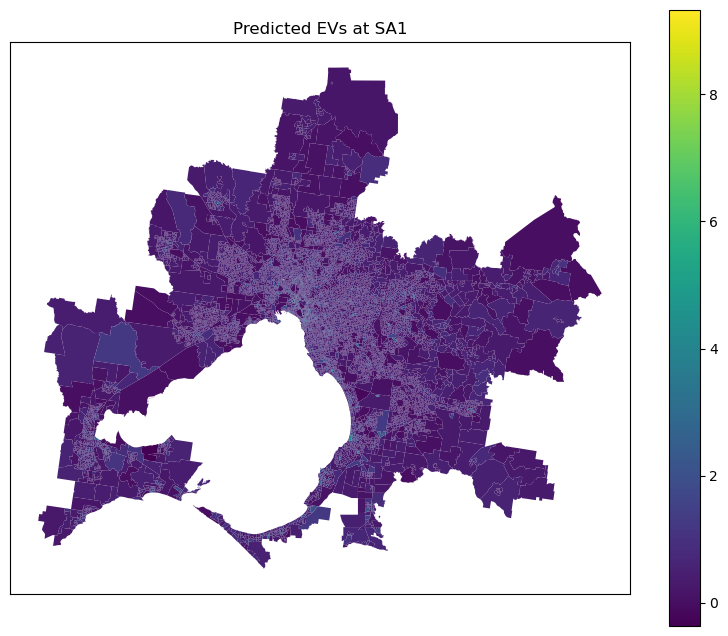

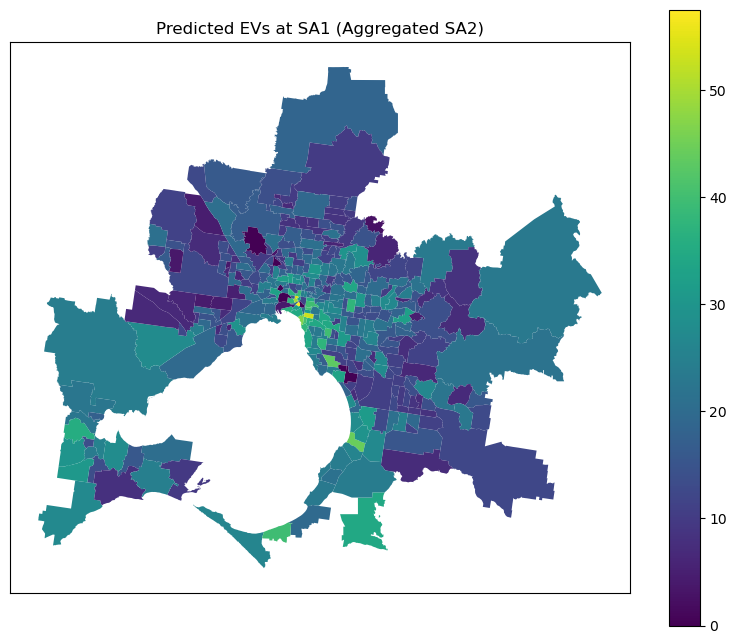

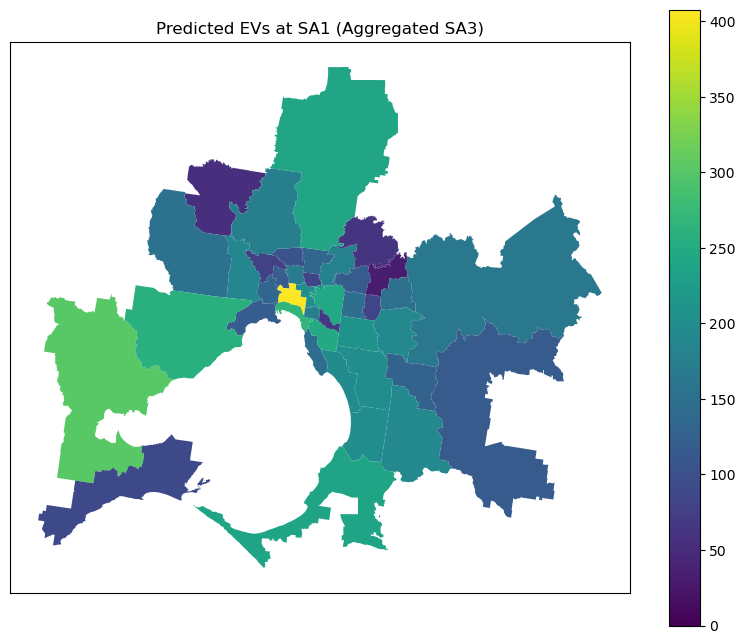

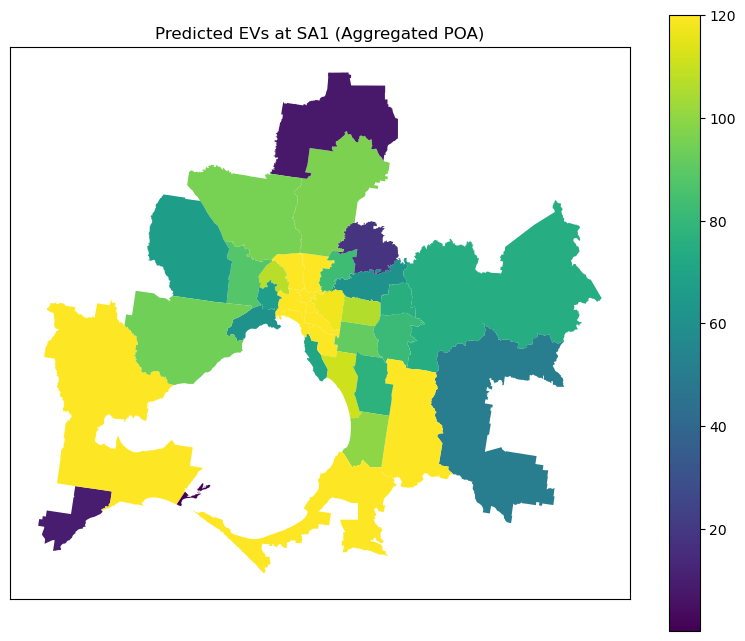

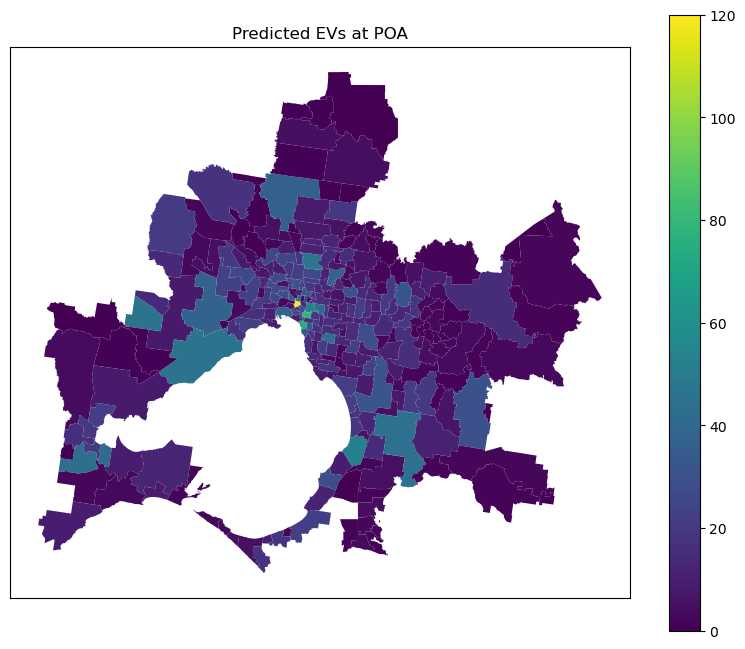

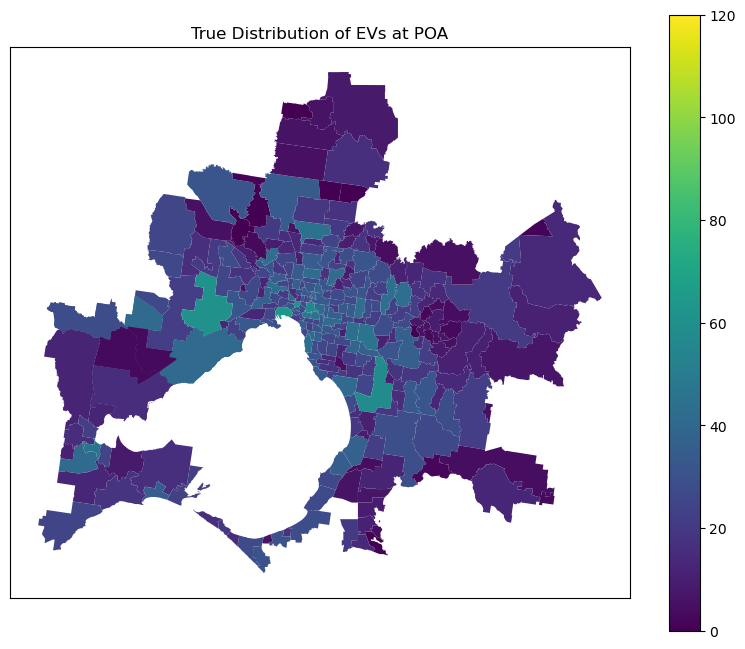

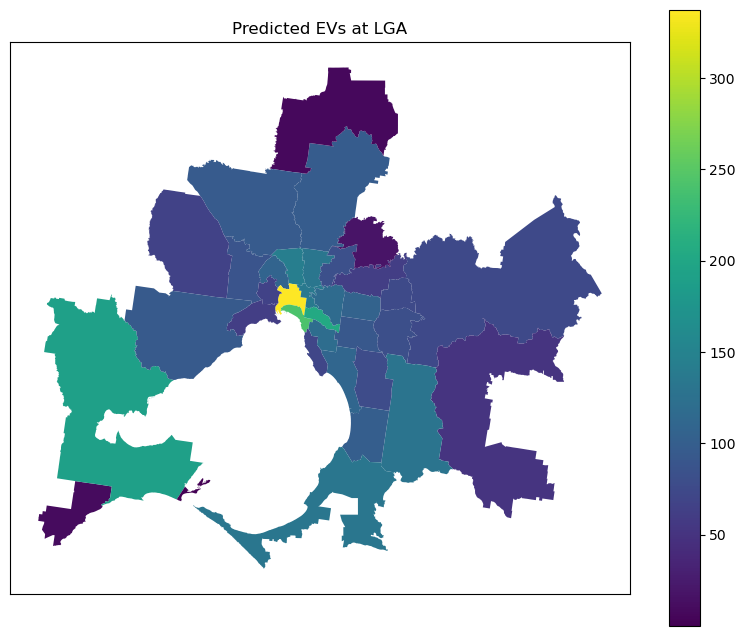

In [ ]:
plot_size = (10, 8)

# Create a plot for the SA1
fig, ax = plt.subplots(figsize=plot_size)
pred_sa1_sa4.plot(column="pred_evs", legend=True, cmap='viridis', ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Predicted EVs at SA1")
plt.show()

# Create a plot for the SA2 Agg
fig, ax = plt.subplots(figsize=plot_size)
clipped_pred_sa2.plot(column="pred_evs", legend=True, cmap='viridis', ax=ax) 
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Predicted EVs at SA1 (Aggregated SA2)") 
plt.show()

# Create a plot for the SA3 Agg
fig, ax = plt.subplots(figsize=plot_size)
clipped_pred_sa3.plot(column="pred_evs", legend=True, cmap='viridis', ax=ax)  
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Predicted EVs at SA1 (Aggregated SA3)")
plt.show()

# Create a plot for the POA Agg
fig, ax = plt.subplots(figsize=plot_size)
clipped_pred_poa.plot(column="pred_evs", legend=True, cmap='viridis', ax=ax, vmax=120)  
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Predicted EVs at SA1 (Aggregated POA)")
plt.show()

# Create a plot for the POA 
fig, ax = plt.subplots(figsize=plot_size)
pred_poa_geo.plot(column="pred_evs", legend=True, cmap='viridis', ax=ax, vmax=120)  
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Predicted EVs at POA")
plt.show()

# Create a plot for the POA Real
fig, ax = plt.subplots(figsize=plot_size)
true_ev_poa.plot(column="TOTAL1", legend=True, cmap='viridis', ax=ax, vmax=120)  
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("True Distribution of EVs at POA")
plt.show()

# Create a plot for the LGA Pred
fig, ax = plt.subplots(figsize=plot_size)
clipped_pred_lga.plot(column="pred_evs", legend=True, cmap='viridis', ax=ax)  
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Predicted EVs at LGA")
plt.show()

<Axes: >

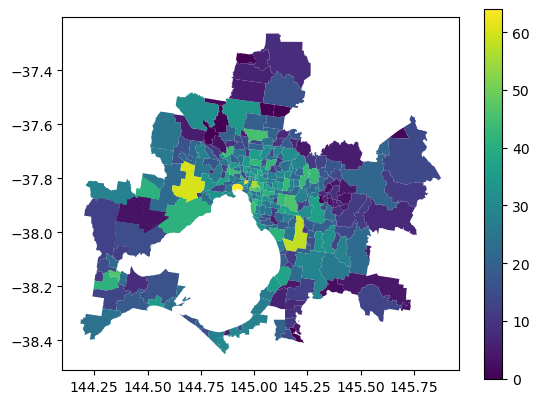

In [ ]:
true_ev_poa.plot(column="TOTAL1", legend=True, cmap='viridis')

<Axes: >

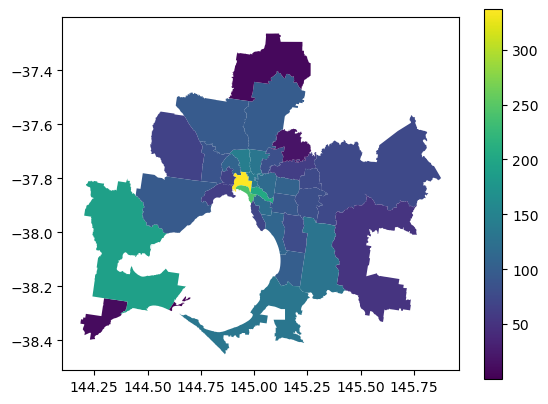

In [ ]:
clipped_pred_poa.plot(column="pred_evs", legend=True, cmap='viridis')

In [21]:
true_ev_poa["TOTAL1"].sum()

6560.0

In [23]:
pred_poa_geo["pred_evs"].sum()

3654.3074